## The Dataset for Pretraining BERT

In [1]:
import os
import random
import torch
from d2l import torch as d2l

## The WikiText-2 dataset

在WikiText-2数据集中，每行代表一个段落，其中在任意标点符号及其前面的词元之间插入空格。保留至少有两句话的段落。为了简单起见，我们仅使用句号作为分隔符来拆分句子。我们将更复杂的句子拆分技术的讨论留在本节末尾的练习中。


In [14]:
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [33]:
wiki_data = _read_wiki("../data/wiki/wikitext-2")
wiki_data[0]
paragraphs = [d2l.tokenize(paragraph, token='word') for paragraph in wiki_data]
sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
sentences[0:1]

[['to',
  'commemorate',
  'the',
  'centenary',
  'of',
  'the',
  'first',
  'performance',
  'of',
  'the',
  'play',
  ',',
  'radio',
  '4',
  'broadcast',
  'a',
  'new',
  'adaptation',
  'on',
  '13',
  'february',
  '1995',
  ';',
  'directed',
  'by',
  'glyn',
  '<unk>',
  ',',
  'it',
  'featured',
  'judi',
  'dench',
  'as',
  'lady',
  'bracknell',
  ',',
  'michael',
  '<unk>',
  'as',
  'lane',
  ',',
  'michael',
  'sheen',
  'as',
  'jack',
  'worthing',
  ',',
  'martin',
  '<unk>',
  'as',
  'algernon',
  'moncrieff',
  ',',
  'john',
  '<unk>',
  'as',
  'canon',
  'chasuble',
  ',',
  'miriam',
  '<unk>',
  'as',
  'miss',
  'prism',
  ',',
  'samantha',
  'bond',
  'as',
  'gwendolen',
  'and',
  'amanda',
  'root',
  'as',
  'cecily']]

## 生成下一句预测任务的数据

In [8]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs是三重列表的嵌套
        # paragraphs是一段话
        # 从中随机抽样一个句子
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

下面的函数通过调用_get_next_sentence函数从输入paragraph生成用于下一句预测的训练样本。这里paragraph是句子列表，其中每个句子都是词元列表。自变量max_len指定预训练期间的BERT输入序列的最大长度。

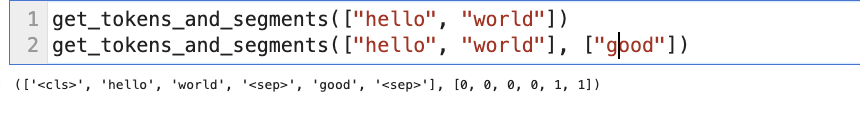

In [37]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    # paragraph[0]是第一句话
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # 考虑1个'<cls>'词元和2个'<sep>'词元
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
            
        # 例如 输入：get_tokens_and_segments(["hello", "world"], ["good"]) 
        # 输出 : (['<cls>', 'hello', 'world', '<sep>', 'good', '<sep>'], [0, 0, 0, 0, 1, 1])
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

## 生成遮蔽语言模型任务的数据¶

为了从BERT输入序列生成遮蔽语言模型的训练样本，我们定义了以下_replace_mlm_tokens函数。在其输入中，tokens是表示BERT输入序列的词元的列表，candidate_pred_positions是不包括特殊词元的BERT输入序列的词元索引的列表（特殊词元在遮蔽语言模型任务中不被预测），以及num_mlm_preds指示预测的数量（选择15%要预测的随机词元）。在 14.8.5.1节中定义遮蔽语言模型任务之后，在每个预测位置，输入可以由特殊的“掩码”词元或随机词元替换，或者保持不变。最后，该函数返回可能替换后的输入词元、发生预测的词元索引和这些预测的标签。


In [36]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    """
    tokens: ['<cls>', 'hello', 'world', '<sep>', 'good', '<sep>']
    """
    # 为遮蔽语言模型的输入创建新的词元副本，其中输入可能包含替换的“<mask>”或随机词元
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # 打乱后用于在遮蔽语言模型任务中获取15%的随机词元进行预测
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            # 达到最大Mask数量就退出
            break
        masked_token = None
        # 80%的时间：将词替换为“<mask>”词元
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10%的时间：保持词不变
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10%的时间：用随机词替换该词
            else:
                # 词典中随机选择
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [35]:
def _get_mlm_data_from_tokens(tokens, vocab):
    """
    tokens: ['<cls>', 'hello', 'world', '<sep>', 'good', '<sep>']
    """
    candidate_pred_positions = []
    # tokens是一个字符串列表
    for i, token in enumerate(tokens):
        # 在遮蔽语言模型任务中不会预测特殊词元
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 遮蔽语言模型任务中预测15%的随机词元, 至少有一个词
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    # 根据pred_positions_and_labels位置排序
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    # 需要预测的位置
    pred_positions = [v[0] for v in pred_positions_and_labels]
    # 真实的Label
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    # 输出: （带掩码的句子的词典编号list, 需要预测的位置， 训练的Label的标号)
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

## 将文本转换为预训练数据集
现在我们几乎准备好为BERT预训练定制一个Dataset类。在此之前，我们仍然需要定义辅助函数_pad_bert_inputs来将特殊的“<mask>”词元附加到输入。它的参数examples包含来自两个预训练任务的辅助函数_get_nsp_data_from_paragraph和_get_mlm_data_from_tokens的输出。



In [45]:
def _pad_bert_inputs(examples, max_len, vocab):
    # 15%的概率将一些词换成 <mask>
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        # (带掩码的句子的词典编号list, 需要预测的位置，训练的Label的词典标号, 段的编码, 是否是下一句的标志)
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # valid_lens不包括'<pad>'的计数
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 填充词元的预测将通过乘以0权重在损失中过滤掉
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    # 带掩码的token的编号(填充<pad>)，所有的段(填充0)， 有效长度，待预测的位置（填充0），预测的label的权重(不预测权重为0)，待预测的label（填充0）
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

## The WikiText-2 dataset for pretraining BERT

In [39]:
class _WikiTextDataset(torch.utils.data.Dataset):
    
    def __init__(self, paragraphs, max_len):
        # 前面的加载数据中，得到的是一个二维数组 例如： [['hello world', 'i am vary happy']]
        # d2l.tokenize, 每一行，按照空格切分
        # 这里拆分得到了每一段
        paragraphs = [d2l.tokenize(paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>'])
        
        # 获取下一句子预测任务的数据
        examples = []
        for paragraph in paragraphs:
            # 对于句子: ['hello', world', 'good']
            # 输出: (['<cls>', 'hello', 'world', '<sep>', 'good', '<sep>'], [0, 0, 0, 0, 1, 1], True)
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # 获取遮蔽语言模型任务的数据
        #  _get_mlm_data_from_tokens的输出:（带掩码的句子的词典编号list, 需要预测的位置， 训练的Label的词典标号)
        # examples：[(带掩码的句子的词典编号list, 需要预测的位置， 训练的Label的词典标号, 段的编码, 是否是下一句的标志)]
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # 填充输入, 并转为Tenser
        # 带掩码的token的编号(填充<pad>)，所有的段(填充0)， 有效长度，待预测的位置（填充0），预测的label的权重(不预测权重为0)，待预测的label（填充0）
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)
        
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])
    def __len__(self):
        return len(self.all_token_ids)

通过使用_read_wiki函数和_WikiTextDataset类，我们定义了下面的load_data_wiki来下载并生成WikiText-2数据集，并从中生成预训练样本。


In [41]:
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

## 查看数据

In [44]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)
for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y) in train_iter:
    # 带掩码的token的编号(填充<pad>)，所有的段(填充0)， 有效长度，待预测的位置（填充0），预测的label的权重(不预测权重为0)，待预测的label（填充0）
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break
# 其中预测的词长度为10(64 * 0.15)

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [46]:
len(vocab)

20256